In [1]:
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

seed=3
np.random.seed(seed)

from keras.layers import Input, Dense
from keras.models import Model

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Concatenate, concatenate
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
labels_df = pd.read_csv('product_attributes_updated.csv', encoding='utf-8', 
                    dialect='excel', lineterminator='\n')

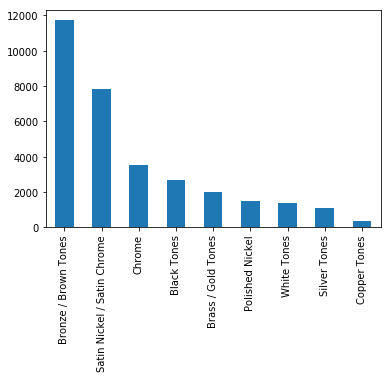

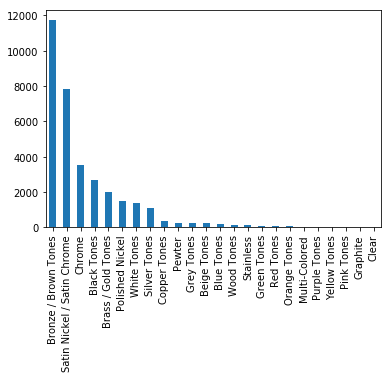

In [3]:
def delete_rare_records(treshold,column_name):
    global labels_df
    e = labels_df[column_name].value_counts()
    return labels_df[labels_df[column_name].isin(e[e>treshold].index)]
cleaned_labels_df=delete_rare_records(treshold=300,column_name='Finish1')
cleaned_labels_df['Finish1'].value_counts().plot(kind="bar")
plt.show()
labels_df['Finish1'].value_counts().plot(kind="bar")
plt.show()

In [4]:
len(labels_df)

34336

In [5]:
len(cleaned_labels_df)

32035

In [6]:
key_words=['Bronze','Brown','Satin','Chrome','Black','Brass','Gold','Polished','White','Silver','Copper','Wall','Sconce','Lamp','Nickel']
dummy=[0]*(len(key_words))
len(dummy)==len(key_words)

True

In [7]:
 def image2np_array( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

x_train_list=[]
y_train_list=[]

found_key_words=[]

one_hot=pd.get_dummies(cleaned_labels_df['Finish1'])

for row in cleaned_labels_df.itertuples():
    if pd.notnull(row[9]):
        try:
            img = image2np_array('..\\ml_150x150\\'+row[1]+'.jpg').reshape(150,150,3)
        except IOError:
            continue
        dummy=[0]*(len(key_words))
        for x in key_words:
            try:
                if x in row[8].split(): 
                    dummy[key_words.index(x)]=1
            except AttributeError:
                continue
        found_key_words.append(dummy)
        x_train_list.append(img)
        y_train_list.append(one_hot.loc[row[0],:].values)

In [9]:
x_train=np.array(x_train_list)
found_key_words=np.array(found_key_words)
y_train=np.array(y_train_list)

In [10]:
y_train.shape

(32030, 9)

In [13]:
epochs = 5
batch_size = 32

input_img = Input(shape=(150, 150, 3))


x=Conv2D(32,(5,5), activation='relu')(input_img)
x=Conv2D(32,(5,5), activation='relu')(x)
x=MaxPooling2D((4, 4), strides=(2, 2), padding='same')(x)

x=Conv2D(32,(5,5), activation='relu')(x)
x=Conv2D(32,(5,5), activation='relu')(x)
x=MaxPooling2D((4, 4), strides=(2, 2), padding='same')(x)

x=Conv2D(32,(5,5), activation='relu')(x)
x=Conv2D(32,(5,5), activation='relu')(x)
x=MaxPooling2D((4, 4), strides=(2, 2), padding='same')(x)

tower_1 = Conv2D(32, (1, 1), padding='same', activation='relu')(x)
tower_1 = Conv2D(32, (3, 3), padding='same', activation='relu')(tower_1)

tower_2 = Conv2D(32, (1, 1), padding='same', activation='relu')(x)
tower_2 = Conv2D(32, (5, 5), padding='same', activation='relu')(tower_2)

tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
tower_3 = Conv2D(32, (1, 1), padding='same', activation='relu')(tower_3)

aux_output1 = concatenate([tower_1, tower_2, tower_3], axis=1)

features=Flatten()(aux_output1)

extra = Input(shape=(len(key_words),))

x=concatenate([features, extra], axis=1)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output3=Dense(9, activation='softmax')(x)
 
end_model = Model(inputs=[input_img,extra], outputs=output3)
end_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
end_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 150, 150, 3)   0                                            
____________________________________________________________________________________________________
conv2d_12 (Conv2D)               (None, 146, 146, 32)  2432        input_3[0][0]                    
____________________________________________________________________________________________________
conv2d_13 (Conv2D)               (None, 142, 142, 32)  25632       conv2d_12[0][0]                  
____________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)   (None, 71, 71, 32)    0           conv2d_13[0][0]                  
___________________________________________________________________________________________

In [14]:
end_model.fit([x_train,found_key_words], y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

Train on 25624 samples, validate on 6406 samples
Epoch 1/5
25624/25624 [==============================] - 102s - loss: 1.1138 - acc: 0.6582 - val_loss: 0.6842 - val_acc: 0.7982
Epoch 2/5
25624/25624 [==============================] - 101s - loss: 0.5948 - acc: 0.8092 - val_loss: 0.5545 - val_acc: 0.8194
Epoch 3/5
25624/25624 [==============================] - 99s - loss: 0.5422 - acc: 0.8257 - val_loss: 0.5438 - val_acc: 0.8180
Epoch 4/5
25624/25624 [==============================] - 100s - loss: 0.4997 - acc: 0.8345 - val_loss: 0.5680 - val_acc: 0.8239
Epoch 5/5
25624/25624 [==============================] - 101s - loss: 0.4604 - acc: 0.8463 - val_loss: 0.4781 - val_acc: 0.8534


In [ ]:
#from keras.utils import plot_model
#plot_model(end_model, to_file='model.png',show_shapes=True)

In [15]:
end_model.save('Finish1_classifier.h5')